# Objetivo do projeto

O objetivo deste projeto é prever uma série temporal de [vendas de shampoo (datasets em Machine Learning Mastery)](https://machinelearningmastery.com/time-series-datasets-for-machine-learning/) utilizando o modelo de previsão Exponential Smoothing.

# Importação de bibliotecas e dados

## Importando principais bibliotecas para o estudo

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date
from IPython.display import display

In [2]:
# Coletando dados
data = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
    )

# Ajustando em formato de data fictícia
def update_date(month_year):
    year,month = month_year.split('-')
    year = '200' + year
    year,month,day = int(year),int(month),1
    return date(year,month,day)



data['Month'] = data['Month'].apply(update_date)

In [3]:
display(data.head())

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


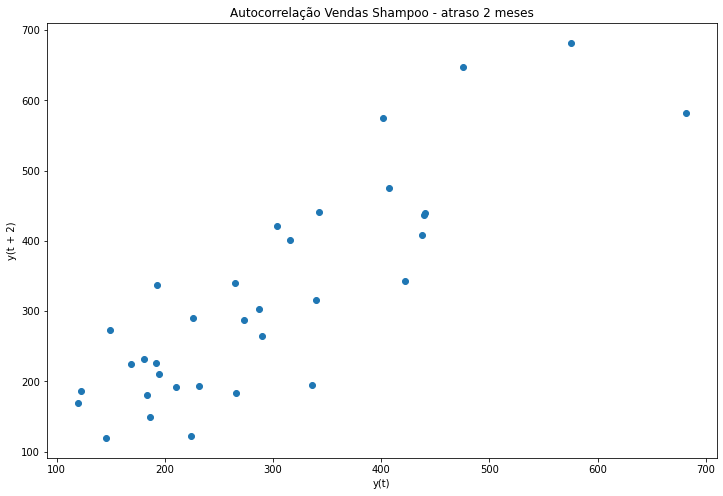

In [4]:
# Verificando o espalhamento das vendas após duas semanas
fig = plt.figure(figsize=(12,8))
pd.plotting.lag_plot(data['Sales'],lag=2)
plt.title('Autocorrelação Vendas Shampoo - atraso 2 meses')
plt.show()

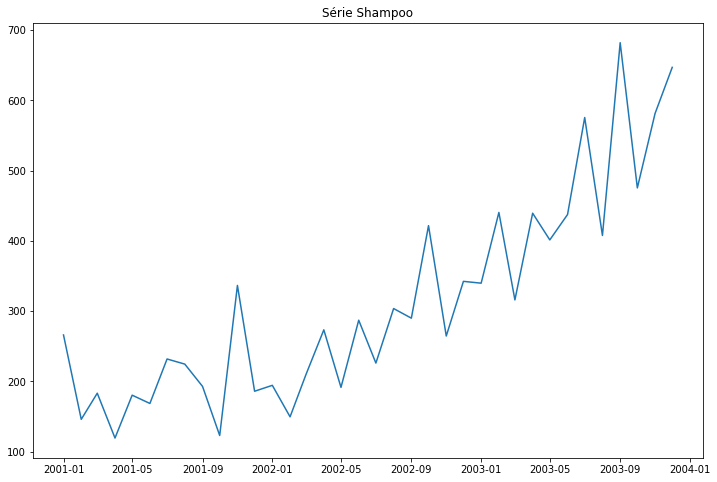

In [5]:
# Verificando o comportamento da série temporal
fig = plt.figure(figsize=(12,8))
plt.plot(data['Month'],data['Sales'])
plt.title('Série Shampoo')
plt.show()

# Exponential Smoothing

Neste notebook iremos treinar o modelo Exponential Smoothing.:

* O modelo Exponential Smoothing é um modelo que para prever os próximos valores utilizamos aproximações lineares, exponenciais ou uma combinação das duas coisas.

* Os parâmetros da Exponential Smoothing variam de acordo com médias móveis exponenciais. As médias móveis exponenciais é uma média móvel onde os pesos das informações mais antigas decaem exponencialmente, de onde vem o nome.

* O treinamento do Exponential Smoothing consiste em encontrar os melhores parâmetros iniciais e qual é o valor do decaimento exponencial, aplicado em cada um dos parâmetros do Exponential Smoothing.


Para informações mais detalhadas pode-se consultar as seguintes referências:
<ul>
    <li><a href="https://otexts.com/fpp2/expsmooth.html">Forecasting: Principles and Practice.</a></li>
    <p>
    <li><a href="https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/">A Gentle Introduction to Exponential Smoothing for Time Series Forecasting in Python.</a></li>
    <p>
    <li><a href="https://web.archive.org/web/20100329135531/http://lorien.ncl.ac.uk/ming/filter/filewma.htm">Exponentially Weighted Moving Average Filter.</a></li>
</ul>

Os principais hiperparâmetros utilizados nesse modelo são os seguintes:

* trend: é o parâmetro que escolhe o tipo de tendência da série temporal, desconsiderando flutuações periódicas. As opções são as seguintes:

  * None : Recomendado quando a série não tem tendência de crescimento nem de decrescimento.

  * 'add' : Recomendado quando a série tem uma tendência linear.

  * 'mul' : Recomendado quando a série tem uma tendência exponencial.

* dampened_trend: Este parâmetro é utilizado para frear a tendência de crescimento. Mais precisamente, a previsão se aproxima de um valor finito se escolhermos ``True`` nesse parâmetro. 

* seasonal: é o parâmetro que escolhe o tipo de comportamento periódico da série temporal. As opções são as seguintes:

  * None : Recomendado quando a série não tem ciclos periódicos bem definidos.

  * 'add' : Recomendado quando a série tem ciclos com amplitude aproximadamente constante (Não é proporcional aos valores da série).

  * 'mul' : Recomendado quando a série tem ciclos com amplitude percentual aproximadamente constante (Proporcional aos valores da série).

* seasonal_periods: controla o comprimento dos ciclos.

* error: controla a natureza dos erros (em valor relativo ou absoluto).

  * 'add' : Nesse caso o erro é calculado como $\varepsilon_{t} = \hat{y}_{t} - y_{t}$. Este é o erro absoluto ou aditivo e recomendado quando queremos reduzir o erro absoluto.

  * 'mul' : Nesse caso o erro é calculado como $\varepsilon_{t} = \dfrac{\hat{y}_{t} - y_{t}}{y_{t}}$. Este é o erro relativo ou multiplicativo e recomendado quando queremos reduzir o erro relativo.

Os parâmetros restantes do ExponentialSmoothing dizem mais respeito à parte de treinamento do modelo, que para informações mais detalhadas pode-se consultar a [documentação oficial do statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html).

# Implementando o modelo


O primeiro modelo terá as seguintes especificações:

* O modelo utilizado será o ExponentialSmoothing com a classe ``statsmodels.tsa.exponential_smoothing.ets.ETSModel``. 

* A divisão de treino e teste é 80%-20%.

* Os hiperparâmetros escolhidos foram ``trend='mul'``, ``damped_trend=True``, ``seasonal='mul'`` e ``seasonal_periods=12``. Esta escolha é uma aposta que a tendência de crescimento é exponencial, com amortecimento, e também uma sazonalidade de 12 meses. Vamos verificar se este modelo é interessante para prever as vendas.

### Importando Módulos

In [6]:
# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


# Utilidades
from tqdm import tqdm # Barra de progresso

# ETSModel statsmodel -> Uma implementação Exponential Smoothing do statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

### Preparação para o treinamento do modelo

In [7]:
# Definindo a série temporal
y = data.values[:,1].astype(float)

# Número de observações
n_examples = len(y)

# Tamanho Conjunto de Treino de 80% do conjunto
train_size = int(n_examples*0.8)
# Tamanho Conjunto de Teste de 20% do conjunto (Complemento do conjunto)
test_size = n_examples - train_size

# Divisão Treino-Teste
y_train = y[:train_size]
y_test = y[train_size:]

In [8]:
# Realizando as previsões
prediction = []
# Histórico de dados
history = y_train.copy()

# Iniciando o modelo Exponential Smoothing
model = ETSModel(history,trend='mul',damped_trend=True,seasonal='mul',seasonal_periods=12)
# Treinando o modelo
model_fit = model.fit()
# Prevendo o próximo valor
ynew = model_fit.forecast()[0]
# Guardando resultado nas previsões
prediction.append(ynew)

for i in tqdm(range(1,test_size)):
  # Atualizando histórico com o dado anterior
  history = np.concatenate((history,[y_test[i-1]]))
  model = ETSModel(history,trend='mul',damped_trend=True,seasonal='mul',seasonal_periods=12)
  model_fit = model.fit(start_params=model_fit.params)
  ynew = model_fit.forecast()[0]
  prediction.append(ynew)

prediction = np.array([prediction[-test_size:]]).T

100%|██████████| 7/7 [00:00<00:00, 10.81it/s]


In [9]:
# Calculando os resíduos e resíduos percentuais
residual = prediction.ravel() - y_test
residual_percentual = 100*residual/y_test

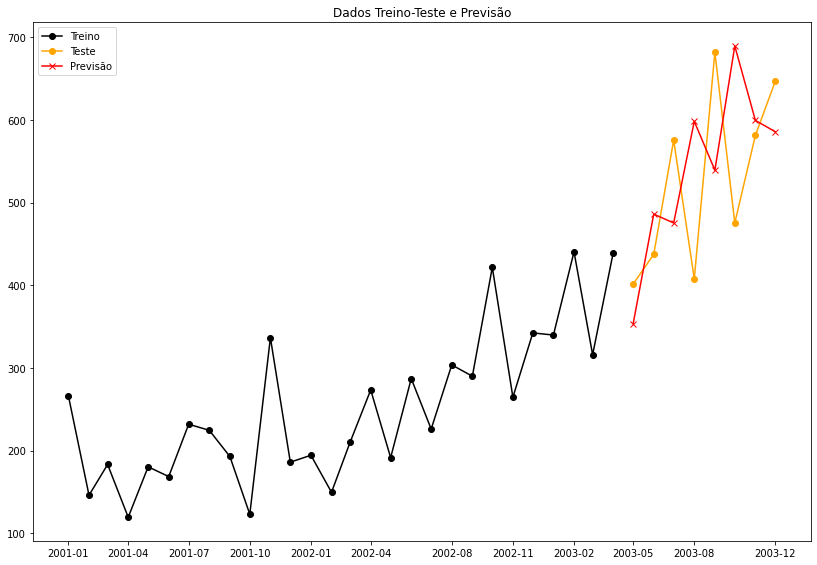

In [10]:
# Formatação de datas matplotlib
import matplotlib.dates as mdates

# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



train_idx = np.array(range(train_size))
test_idx = np.array(range(train_size,n_examples))


plt.title('Dados Treino-Teste e Previsão')
ax.plot(data['Month'][train_idx],y_train,color='k',marker='o',label = 'Treino')
ax.plot(data['Month'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(data['Month'][test_idx],prediction[-test_size:],marker = 'x',color = 'red',label = 'Previsão')



# Formatando datas
index_list = np.linspace(0,n_examples-1,12,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

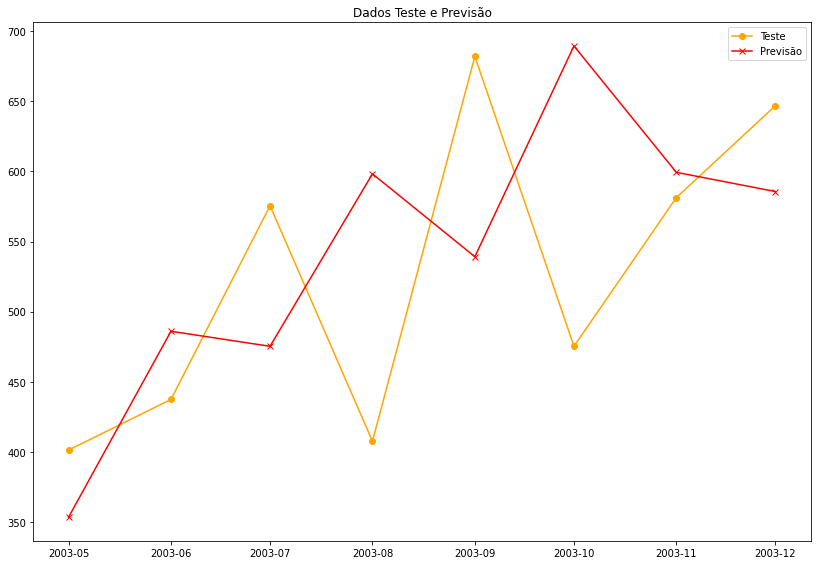

In [11]:
# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Teste e Previsão')
ax.plot(data['Month'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(data['Month'][test_idx],prediction[-test_size:],marker = 'x',color = 'red',label = 'Previsão')





# Formatando datas
index_list = np.linspace(train_size,n_examples-1,min([10,test_size]),dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

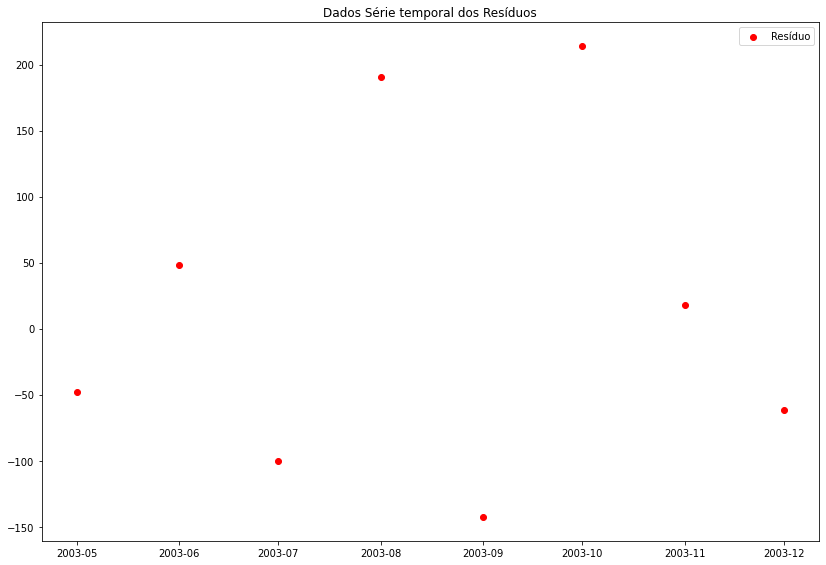

In [12]:
# Plotando Gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(data['Month'][test_idx],residual,marker = 'o',color = 'red',label = 'Resíduo')




# Formatando datas
index_list = np.linspace(train_size,n_examples-1,test_size,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

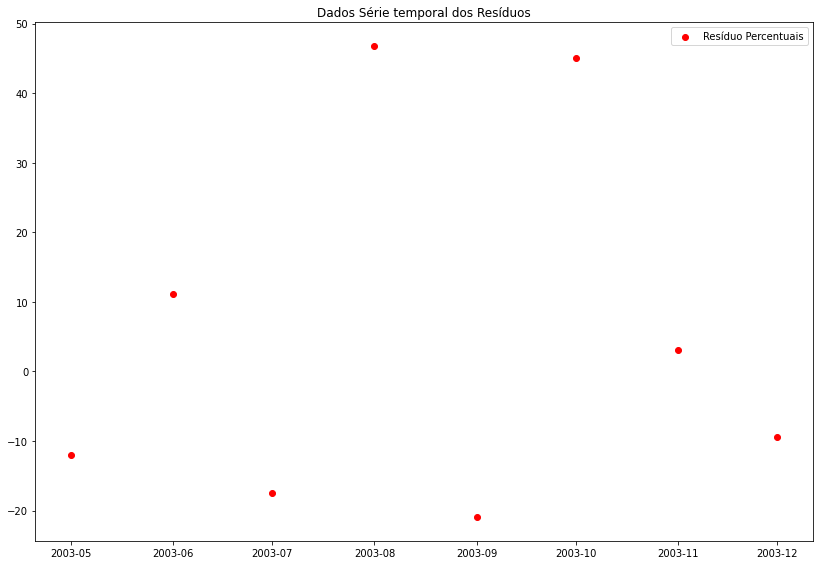

In [13]:
# Plotando gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(data['Month'][test_idx],residual_percentual,marker = 'o',color = 'red',label = 'Resíduo Percentuais')


# Formatando datas
index_list = np.linspace(train_size,n_examples-1,test_size,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

In [14]:
import json
# Verificando o desempenho nos dados de teste
test_pred = prediction[-test_size:]
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}

with open('test_performances_ETS.json','w') as f:
    json.dump(test_performances_dict,f)

test_performances_dict

{'Test MAPE': 20.724251792727305,
 'Test MSE': 15171.321917193172,
 'Test RMSE': 123.17192016524372,
 'Test MAE': 102.94790269286769}

Vemos um erro percentual médio de 20.72% e o raiz quadrada do erro quadrático médio (RMSE) foi de 123.17. Acredito que por não ter um padrão periódico bem definido, a escolha de sazonalidade pode atrapalhar um pouco na precisão. 

Para ter uma noção de precisão vamos comparar o resultado obtido o com da previsão $\hat{y}_{i} = y_{i-1}$. 

In [15]:
# Previsão utilizando o dado anterior
test_pred = np.concatenate(([y_train[-1]],y_test[:-1]))

# Verificando os desempenhos nos dados de teste
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


# Armazenando performances
test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}


with open('test_performances_naive.json','w') as f:
    json.dump(test_performances_dict,f)




# Mostrando os resultados
print('Naive predictor')
for key in test_performances_dict.keys():
    print(key + ': %1.4f' %test_performances_dict[key])

Naive predictor
Test MAPE: 24.3762
Test MSE: 22946.1050
Test RMSE: 151.4797
Test MAE: 129.1000


A princípio a performance da previsão $\hat{y}_{i} = y_{i-1}$ tem uma performance pior que o modelo Exponential Smoothing, isso é um sinal que o nosso modelo consegue agregar valor aos dados na forma de previsão.

Vamos comparar o Exponential Smoothing escolhido com o mesmo modelo, porém desconsiderando sazonalidade.

In [16]:
# Realizando novamente as previsões
prediction = []
history = y_train.copy()

model = ETSModel(history,trend='mul',damped_trend=True)
model_fit = model.fit()
ynew = model_fit.forecast()[0]
prediction.append(ynew)

for i in tqdm(range(1,test_size)):
  history = np.concatenate((history,[y_test[i-1]]))
  model = ETSModel(history,trend='mul',damped_trend=True)
  model_fit = model.fit(start_params=model_fit.params)
  ynew = model_fit.forecast()[0]
  prediction.append(ynew)

prediction = np.array([prediction[-test_size:]]).T

100%|██████████| 7/7 [00:00<00:00, 44.41it/s]


In [17]:
test_pred = prediction
# Verificando os desempenhos nos dados de teste
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}

with open('test_performances_ETS2.json','w') as f:
    json.dump(test_performances_dict,f)

test_performances_dict

{'Test MAPE': 13.84895321820192,
 'Test MSE': 7609.416267366496,
 'Test RMSE': 87.23196815025152,
 'Test MAE': 71.70780391554449}

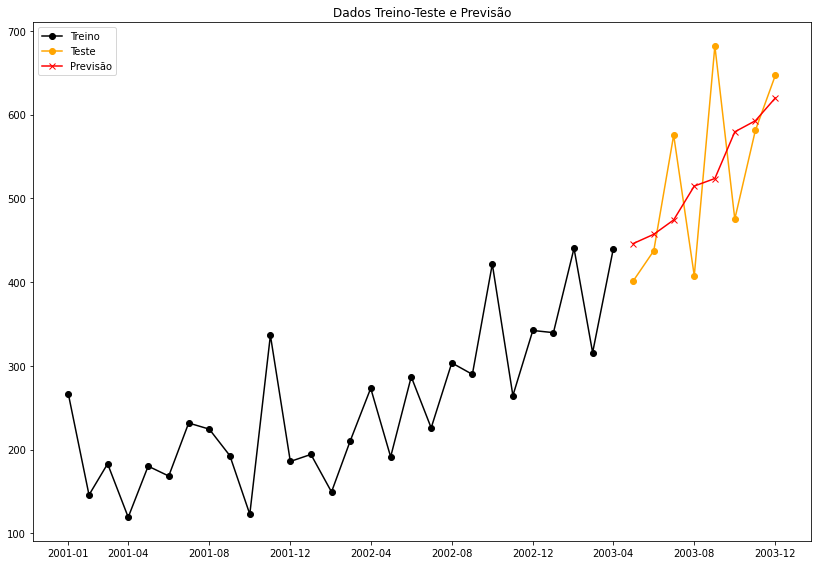

In [18]:
# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



train_idx = np.array(range(train_size))
test_idx = np.array(range(train_size,n_examples))

plt.title('Dados Treino-Teste e Previsão')
ax.plot(data['Month'][train_idx],y_train,color='k',marker='o',label = 'Treino')
ax.plot(data['Month'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(data['Month'][test_idx],test_pred,marker = 'x',color = 'red',label = 'Previsão')





# Formatando datas
index_list = np.linspace(0,n_examples-1,10,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

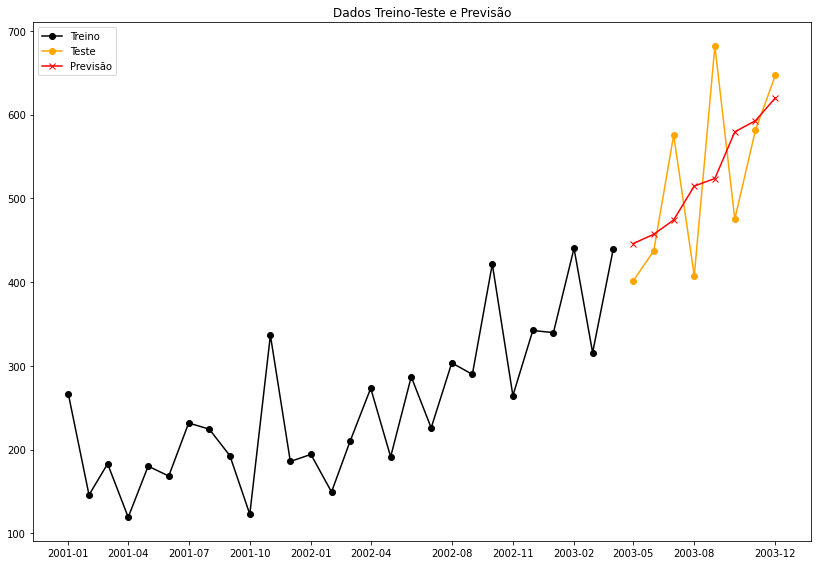

In [19]:
# Formatação de datas matplotlib
import matplotlib.dates as mdates

# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



train_idx = np.array(range(train_size))
test_idx = np.array(range(train_size,n_examples))


plt.title('Dados Treino-Teste e Previsão')
ax.plot(data['Month'][train_idx],y_train,color='k',marker='o',label = 'Treino')
ax.plot(data['Month'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(data['Month'][test_idx],prediction[-test_size:],marker = 'x',color = 'red',label = 'Previsão')



# Formatando datas
index_list = np.linspace(0,n_examples-1,12,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

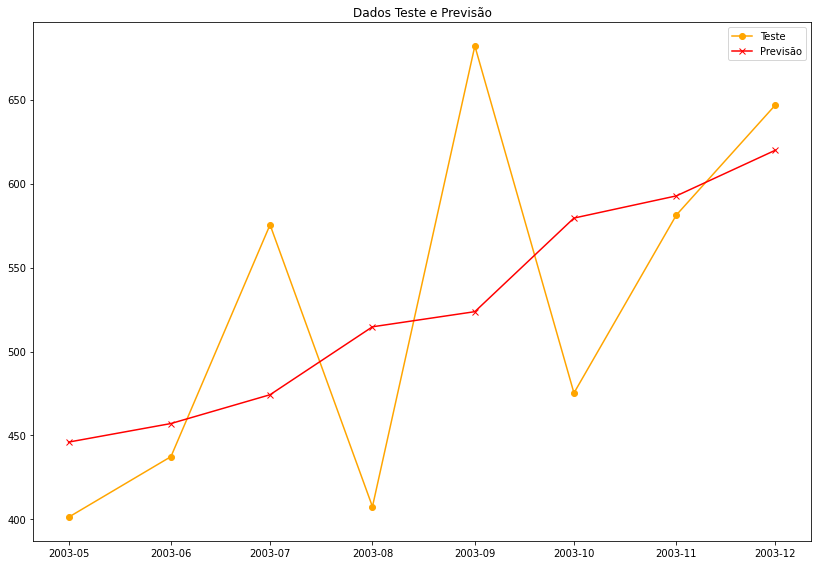

In [20]:
# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Teste e Previsão')
ax.plot(data['Month'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(data['Month'][test_idx],prediction[-test_size:],marker = 'x',color = 'red',label = 'Previsão')





# Formatando datas
index_list = np.linspace(train_size,n_examples-1,min([10,test_size]),dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

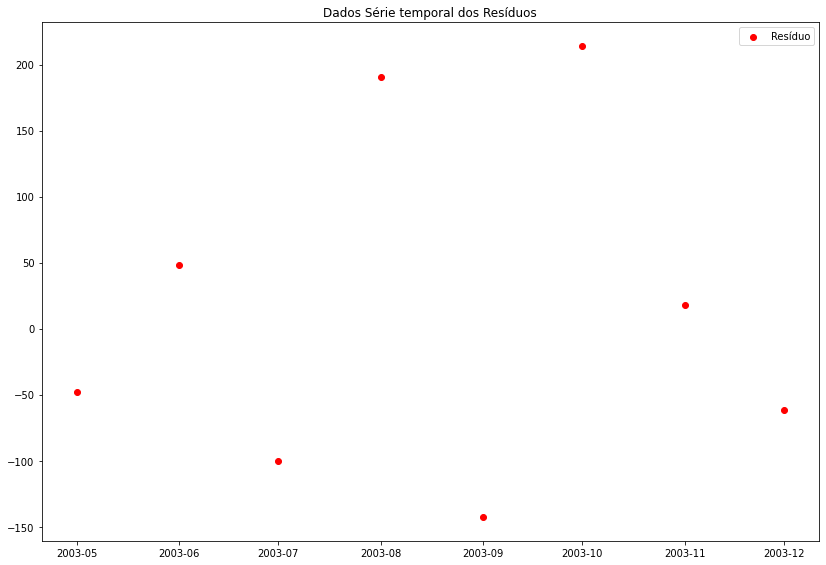

In [21]:
# Plotando Gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(data['Month'][test_idx],residual,marker = 'o',color = 'red',label = 'Resíduo')




# Formatando datas
index_list = np.linspace(train_size,n_examples-1,test_size,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

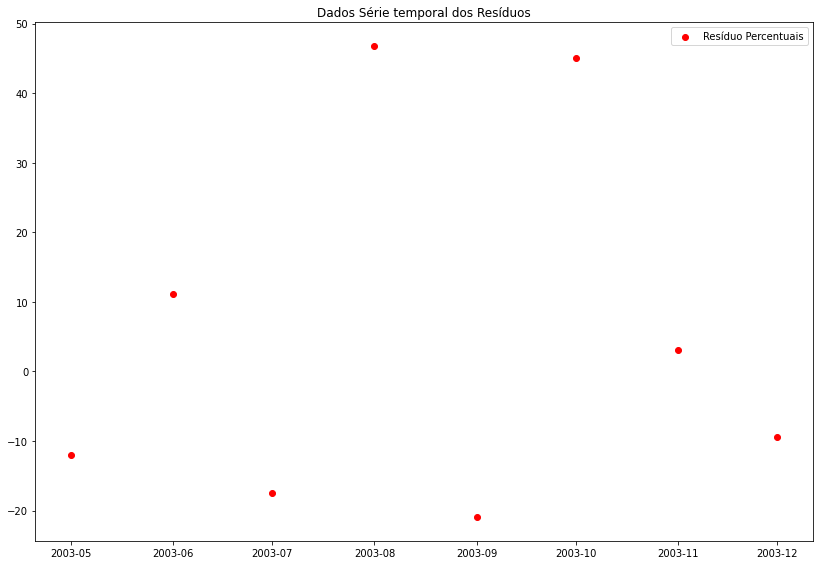

In [22]:
# Plotando gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



test_idx = np.array(range(train_size,n_examples))
plt.title('Dados Série temporal dos Resíduos')
ax.scatter(data['Month'][test_idx],residual_percentual,marker = 'o',color = 'red',label = 'Resíduo Percentuais')


# Formatando datas
index_list = np.linspace(train_size,n_examples-1,test_size,dtype=int)

plt.xticks(ticks=data['Month'][index_list])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.legend()
plt.show()

Temos um MAPE de 13.06% e RMSE de 87.23. Portanto uma redução significativa no erro, porém não conseguimos captar possíveis variações periódicas.

Além disso, apesar de não ser o objetivo do projeto, o agregado trimestral pode ser um pouco mais regular e portanto mais fácil de captar padrões periódicos.

In [23]:
trimestral_data = {}

# Definindo o número de trimestres total
n_trim = n_examples//3 if n_examples%3 == 0 else n_examples//3+1


for i in range(n_trim):
    # Encontrando o ano
    year = data['Month'][3*i].year
    # Encontrando o trimestre correspondente
    trim = i%4 + 1
    trim_year = str(trim) + ' Trim. ' + str(year)
    # Aplicando os dados no dicionário
    trimestral_data[i] = {'Trim.':trim_year,'Sales':data['Sales'][3*i:3*(i+1)].sum()}
# Transformando o dicionário em DataFrame
trimestral_data = pd.DataFrame(trimestral_data).T
trimestral_data.head()

,Trim.,Sales
0,1 Trim. 2001,595.0
1,2 Trim. 2001,468.1
2,3 Trim. 2001,649.1
3,4 Trim. 2001,645.3
4,1 Trim. 2002,553.9


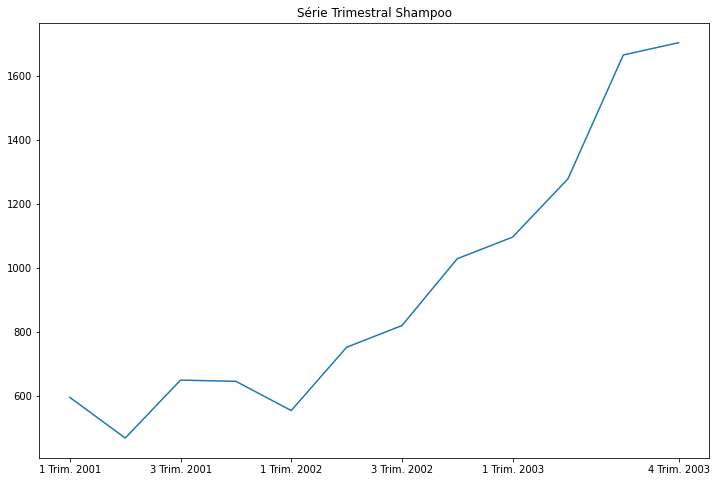

In [24]:
# Verificando o comportamento da série temporal trimestral
fig = plt.figure(figsize=(12,8))
plt.plot(trimestral_data['Trim.'],trimestral_data['Sales'])
plt.title('Série Trimestral Shampoo')

# Formatando datas
index_list = np.linspace(0,n_trim-1,n_trim//2,dtype=int)

plt.xticks(ticks=trimestral_data['Trim.'][index_list])

plt.show()

Nesse caso o agregado trimestral é bastante regular e o volume de vendas cresce em um formato quase exponencial. 

Então podemos ver que utilizar os dados agregados pode eventualmente nos dar uma precisão maior. Caso a previsão mensal seja estritamente necessária e em grau de precisão maior, então devemos utilizar modelos outros modelos, que podem ser mais complexos, e obter outros dados que podem ajudar na previsão.

In [25]:
# Definindo a série temporal
y = trimestral_data.values[:,1].astype(float)

# Número de observações
n_trim = len(y)

# Tamanho Conjunto de Treino de 80% do conjunto
train_size = int(n_trim*0.8)
# Tamanho Conjunto de Teste de 20% do conjunto (Complemento do conjunto)
test_size = n_trim - train_size

# Divisão Treino-Teste
y_train = y[:train_size]
y_test = y[train_size:]

In [26]:
# Realizando novamente as previsões
prediction = []
history = y_train.copy()

model = ETSModel(history,trend='mul',damped_trend=True)
model_fit = model.fit()
ynew = model_fit.forecast()[0]
prediction.append(ynew)

for i in tqdm(range(1,test_size)):
  history = np.concatenate((history,[y_test[i-1]]))
  model = ETSModel(history,trend='mul',damped_trend=True)
  model_fit = model.fit(start_params=model_fit.params)
  ynew = model_fit.forecast()[0]
  prediction.append(ynew)

prediction = np.array([prediction[-test_size:]]).T

100%|██████████| 2/2 [00:00<00:00, 51.31it/s]


In [27]:
test_pred = prediction
# Verificando as performances dos novos dados
MAPE_test = 100*mean_absolute_percentage_error(y_test,test_pred)
MSE_test = mean_squared_error(y_test,test_pred)
RMSE_test = np.sqrt(MSE_test)
MAE_test = mean_absolute_error(y_test,test_pred)


test_performances_dict = {'Test MAPE':MAPE_test,
                    'Test MSE':MSE_test,
                    'Test RMSE':RMSE_test,
                    'Test MAE':MAE_test}

with open('test_performances_ETS_aggregated.json','w') as f:
    json.dump(test_performances_dict,f)

test_performances_dict

{'Test MAPE': 7.9708221183963905,
 'Test MSE': 20936.177336817447,
 'Test RMSE': 144.69339078485046,
 'Test MAE': 129.664372355967}

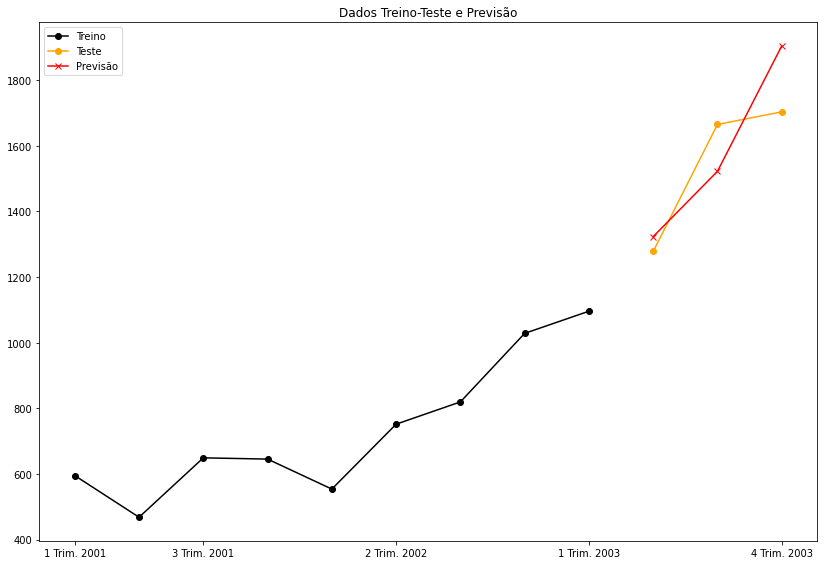

In [28]:
# Plotando os gráficos
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([.1,.1,.9,.9])



train_idx = np.array(range(train_size))
test_idx = np.array(range(train_size,n_trim))

plt.title('Dados Treino-Teste e Previsão')
ax.plot(trimestral_data['Trim.'][train_idx],y_train,color='k',marker='o',label = 'Treino')
ax.plot(trimestral_data['Trim.'][test_idx],y_test,color = 'orange',marker = 'o',label = 'Teste')
ax.plot(trimestral_data['Trim.'][test_idx],test_pred,marker = 'x',color = 'red',label = 'Previsão')





# Formatando datas
index_list = np.linspace(0,n_trim-1,5,dtype=int)

plt.xticks(ticks=trimestral_data['Trim.'][index_list])


plt.legend()
plt.show()

Neste caso as previsões realmente foram mais precisas, com MAPE de 7.97% e RMSE de 144.69. Devemos levar em conta que os valores por previsão são maiores e neste caso, ainda com RMSE ligeiramente maior, a precisão relativa é maior.

# Conclusões

Aqui aprendemos um pouco sobre exponential smoothing e algumas configurações básicas.

Além disso, podemos tirar as seguintes conclusões da experiência obtida:

* O modelo pode ser bastante sensível às configurações de sazonalidade. Portanto devemos configurar com cuidado estes parâmetros. 

* Por outro lado, o modelo sem os parâmetros de sazonalidade podem ser bastante simples e não captar todo o comportamento. Para isso devemos fazer a escolha que mais fizer sentido para o propósito do projeto. Eventualmente necessitamos da utilização de mais dados ou modelos mais complexos para captar melhor os detalhes.

* Se fizer sentido, algumas vezes a agregação dos dados em intervalos maiores e consolidar em um volume maior pode trazer mais regularidade à série temporal, o que pode ser mais fácil de realizar previsões, como mostrado no exemplo. Por outro lado, algumas vezes podemos precisar de informações mais imediatas, o que em certo ponto invalida a abordagem.